In [1]:
# For query
import sys   
sys.path.append('../../src/data')
import query_flights as query
from datetime import date

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
ls ../../data/processed

airlines.db


In [3]:
path_to_db = "sqlite:///../../data/processed/airlines.db"

In [4]:
import pandas as pd
from datetime import date
from sqlalchemy import create_engine
import calendar

def enhance_flights_by_day_of_week(data):
    # Provide human readable names for Day of week
    data['day_of_week'] = data['dow_int'].apply(lambda x: calendar.day_name[x - 1])
    
    # Calculate the fraction of the total flights that occured on a given day of the week
    total_flights = sum(data['flight_count'])
    data['fraction_of_total_flights'] = data['flight_count'] / total_flights
    
    data['daily_fraction_cancelled'] = data['cancelled_flights'] / data['flight_count']
    data['daily_fraction_departure_delays'] = data['departure_delays'] / data['flight_count']
    data['daily_fraction_arrival_delays'] = data['arrival_delays'] / data['flight_count']
    return data

def query_flights_by_day_of_week(start_date=None, end_date=None, path_to_db=None):
  
    # If no date constraints are provided, limit to one month of data
    if start_date is None:
        start_date = date(2017, 1, 1)
    if end_date is None:
        end_date = date(2017, 1, 31)
        
    engine = create_engine(path_to_db)
    with engine.connect() as conn:
        flights = pd.read_sql("""
            SELECT 
                f.day_of_week as dow_int,
                sum(f.flights) as flight_count,
                sum(f.departure_was_delayed_15) as departure_delays,
                sum(f.arrival_was_delayed_15) as arrival_delays,
                sum(f.cancelled) as cancelled_flights
            FROM 
                flights AS f
            WHERE
                f.flight_date 
            BETWEEN :start_date 
                AND :end_date
            GROUP BY 
                f.day_of_week
        """, conn, 
        params={'start_date': start_date, 'end_date': end_date})
    
    return enhance_flights_by_day_of_week(flights)
        
start_date = date(2017, 1, 1)
end_date = date(2017, 12, 31) 
flights = query_flights_by_day_of_week(start_date, end_date, path_to_db)  

In [5]:
flights.head(8)

,dow_int,flight_count,departure_delays,arrival_delays,cancelled_flights,day_of_week,fraction_of_total_flights,daily_fraction_cancelled,daily_fraction_departure_delays,daily_fraction_arrival_delays
0,1,839772,161766,164832,14844,Monday,0.148328,0.017676,0.192631,0.196282
1,2,819499,131343,133665,12892,Tuesday,0.144747,0.015732,0.160272,0.163106
2,3,830854,137687,141238,10469,Wednesday,0.146753,0.012600,0.165717,0.169991
3,4,841765,161306,165721,11599,Thursday,0.148680,0.013779,0.191628,0.196873
4,5,846443,171713,175540,12194,Friday,0.149506,0.014406,0.202864,0.207385
5,6,689412,110398,108849,9483,Saturday,0.121770,0.013755,0.160134,0.157887
6,7,793855,136433,136558,11128,Sunday,0.140217,0.014018,0.171861,0.172019


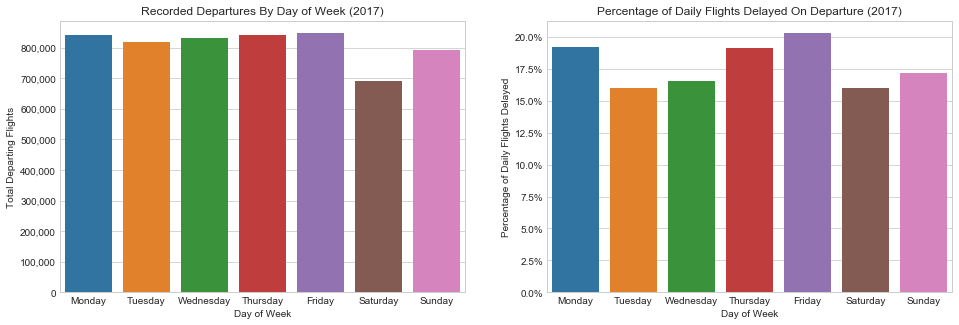

In [6]:
a4_dims = (16, 5)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=a4_dims)

_ = sns.barplot(data=flights, x='day_of_week', y='flight_count', ax=ax1)
_ = ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
_ = ax1.set_title('Recorded Departures By Day of Week (2017)')
_ = ax1.set_xlabel('Day of Week')
_ = ax1.set_ylabel('Total Departing Flights')

_ = sns.barplot(data=flights, x='day_of_week', y='daily_fraction_departure_delays', ax=ax2)
_ = ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{round(x*100, 2)}%"))
_ = ax2.set_title('Percentage of Daily Flights Delayed On Departure (2017)')
_ = ax2.set_xlabel('Day of Week')
_ = ax2.set_ylabel('Percentage of Daily Flights Delayed')

plt.savefig("../../reports/figures/departures-by-day-of-week.png")

plt.show()